In [2]:
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pathlib import Path
from helpers.utils import LaughterDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Load labels and add numerical mapping to laugh class
labels = pd.read_csv('data/labels.csv')
mappings = {'belly': 0, 'chuckle': 1, 'baby': 2, 'evil': 3} 
labels['laugh_numerical'] = labels['laugh_class'].map(mappings)

In [4]:
ROOT_PATH = Path('data/training-dataset')

# Split between training (75%) and testing (25%) labels 
training_labels, testing_labels = train_test_split(labels, train_size=0.75, test_size=0.25)

# This will return datasets splited between training and labels
training_dataset = LaughterDataset(ROOT_PATH, labels=training_labels)
testing_dataset = LaughterDataset(ROOT_PATH, labels=testing_labels)

# Creating Dataloaders for Neural Network
train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=8, shuffle=False)

In [5]:
class LaughCNN(nn.Module):
	def __init__(self):
		super(LaughCNN, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(1, 16, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2),
			nn.Conv2d(16, 32, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)
		self.fc = nn.Sequential(
			nn.Flatten(),
			nn.Linear(32 * 3 * 32, 64),
			nn.ReLU(),
			nn.Linear(64, 4)
		)

	def forward(self, x):
		x = self.conv(x)
		return self.fc(x)

In [6]:
model = LaughCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_for_iteration = []

for epoch in range(30):
	model.train()
	running_loss = 0.0
	for audio, _, _, numerical in train_loader:
			outputs = model(audio)
			loss = criterion(outputs, numerical)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			running_loss += loss.item()
	loss_for_iteration.append(running_loss/len(train_loader))

	print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}")

Epoch 1: Loss = 2.8568
Epoch 2: Loss = 0.8527
Epoch 3: Loss = 0.7135
Epoch 4: Loss = 0.3755
Epoch 5: Loss = 0.1693
Epoch 6: Loss = 0.0944
Epoch 7: Loss = 0.0476
Epoch 8: Loss = 0.0185
Epoch 9: Loss = 0.0081
Epoch 10: Loss = 0.0048
Epoch 11: Loss = 0.0036
Epoch 12: Loss = 0.0029
Epoch 13: Loss = 0.0021
Epoch 14: Loss = 0.0018
Epoch 15: Loss = 0.0015
Epoch 16: Loss = 0.0013
Epoch 17: Loss = 0.0011
Epoch 18: Loss = 0.0010
Epoch 19: Loss = 0.0008
Epoch 20: Loss = 0.0008
Epoch 21: Loss = 0.0007
Epoch 22: Loss = 0.0006
Epoch 23: Loss = 0.0006
Epoch 24: Loss = 0.0005
Epoch 25: Loss = 0.0005
Epoch 26: Loss = 0.0004
Epoch 27: Loss = 0.0004
Epoch 28: Loss = 0.0004
Epoch 29: Loss = 0.0003
Epoch 30: Loss = 0.0003


In [ ]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
		for audio, audio_id, _, numerical in test_loader:
				outputs = model(audio)
				_, predicted = torch.max(outputs, 1)
				predictions.extend(p.item() for p in predicted)
				true_labels.extend(n.item() for n in numerical)
				
print(f'{'Predicted':>{10}}: {predictions}')
print(f'{'True':>{10}}: {true_labels:}')

 Predicted: [3, 2, 2, 2, 2, 0, 2, 1, 2, 3, 2, 0, 0, 1, 3, 0, 1, 3, 3, 1, 0, 3, 3, 0, 1, 0, 2, 1, 2, 2, 3, 3, 0, 3, 0, 0, 2, 0, 0, 2, 1, 0, 0, 3, 2, 2, 3, 0, 0, 1, 3, 2, 2, 1, 1, 3, 0, 1, 3, 3, 2, 0, 1, 3, 0, 3]
      True: [3, 0, 2, 2, 2, 0, 2, 1, 1, 1, 3, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 3, 0, 2, 3, 3, 2, 0, 0, 0, 1, 3, 2, 2, 1, 1, 3, 3, 1, 3, 3, 2, 1, 1, 3, 3, 3]


In [14]:

accuraccy = accuracy_score(predictions, true_labels)
precision = precision_score(predictions, true_labels, average='macro')
recall = recall_score(predictions, true_labels, average='macro')
F1_score = f1_score(predictions, true_labels, average='macro')
print('Accuracy: ', accuraccy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', F1_score)
print('')

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["chuckle", "baby", "belly", "evil"]))

Accuracy:  0.7121212121212122
Precision:  0.7085375816993464
Recall:  0.722609219126247
F1 Score:  0.7126096684920215

Classification Report:
              precision    recall  f1-score   support

     chuckle       0.74      0.78      0.76        18
        baby       0.83      0.67      0.74        15
       belly       0.76      0.76      0.76        17
        evil       0.56      0.62      0.59        16

    accuracy                           0.71        66
   macro avg       0.72      0.71      0.71        66
weighted avg       0.72      0.71      0.71        66



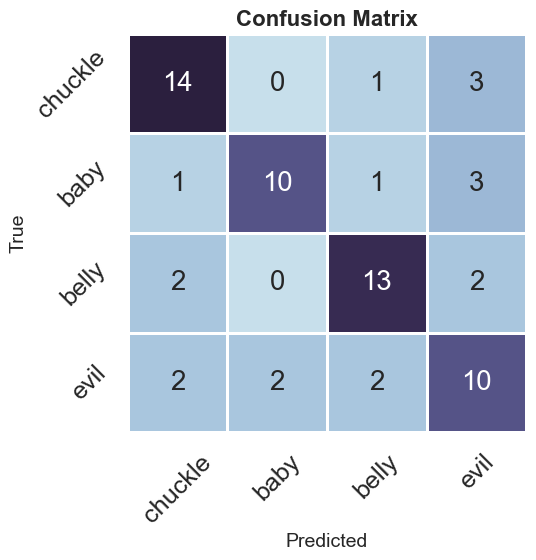

In [15]:
tags = ["chuckle", "baby", "belly", "evil"]

plt.figure(figsize=(7, 6))
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap=cmap,
    xticklabels=tags,
    yticklabels=tags,
    linewidths=1,
    linecolor='white',
    cbar=False,
    square=True
)

ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("True", fontsize=14)
ax.set_title("Confusion Matrix", fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


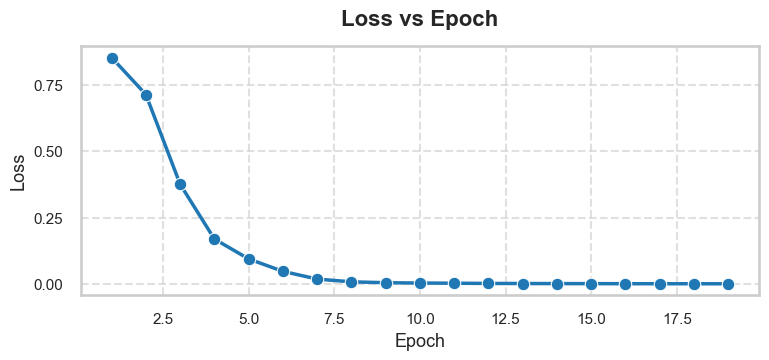

In [16]:
df = pd.DataFrame({
    'Epoch': range(1, 20),
    'Loss': loss_for_iteration[1:20]
})

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df,
    x='Epoch',
    y='Loss',
    marker='o',
    linewidth=2.5,
    color="#1f77b4",
)

# Plot
plt.title("Loss vs Epoch", fontsize=16, weight='bold', pad=15)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()